# Data Structures and Indexing

We'll get our first look at pandas' data structures.
Then we'll focus on indexing -- selecting subsets of data.

In [1]:
import numpy as np
import pandas as pd
import seaborn.apionly as sns
import matplotlib.pyplot as plt

/python/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/python/anaconda/lib/python2.7/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [2]:
%matplotlib inline

In [3]:
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams['figure.figsize'] = (16, 12)

## Reading Data

Pandas has support for reading from many data sources, including

- `pd.read_csv`
- `pd.read_excel`
- `pd.read_html`
- `pd.read_json`
- `pd.read_hdf`
- `pd.read_sql`
- `pd.read_csv`

For this section we'll work with some flights data from the US Bureau of Transportation and Statistics.
The CSV includes all the flights from New York airports in January 2014.
Each record has information about a single flight including the carrier, tail number, origin, destination, and delays.

In [13]:
flights = pd.read_csv("data/ny-flights.csv.gz",
                      parse_dates=["fl_date", "arr", "dep"])
flights.head()

,fl_date,unique_carrier,airline_id,tail_num,fl_num,origin,dest,dep_time,dep_delay,arr_time,arr_delay,cancelled,arr,dep
0,2014-01-01,AA,19805,N338AA,1,JFK,LAX,914.00,14.00,"1,238.00",13.00,0.00,2014-01-01 12:38:00,2014-01-01 09:14:00
1,2014-01-01,AA,19805,N335AA,3,JFK,LAX,"1,157.00",-3.00,"1,523.00",13.00,0.00,2014-01-01 15:23:00,2014-01-01 11:57:00
2,2014-01-01,AA,19805,N327AA,21,JFK,LAX,"1,902.00",2.00,"2,224.00",9.00,0.00,2014-01-01 22:24:00,2014-01-01 19:02:00
3,2014-01-01,AA,19805,N3EHAA,29,LGA,PBI,722.00,-8.00,"1,014.00",-26.00,0.00,2014-01-01 10:14:00,2014-01-01 07:22:00
4,2014-01-01,AA,19805,N319AA,117,JFK,LAX,"1,347.00",2.00,"1,706.00",1.00,0.00,2014-01-01 17:06:00,2014-01-01 13:47:00


## Data Structures

![A dataframe is made up of data, row labels, and column labels](figures/dataframe.png)

`read_csv` returned a `DataFrame`, which is somewhat similar to a spreadsheet or database table.
`pd.DataFrame` is the data container you'll work most with, and consists of a few components:

The data are in the middle of the table.
Each column of the data is a `pd.Series`, kind of like a 1-dimensional version of a DataFrame.

In [19]:
s = list(flights.columns)

In [20]:
s

['fl_date',
 'unique_carrier',
 'airline_id',
 'tail_num',
 'fl_num',
 'origin',
 'dest',
 'dep_time',
 'dep_delay',
 'arr_time',
 'arr_delay',
 'cancelled',
 'arr',
 'dep']

In [5]:
flights['dep_delay']

0        14.00
1        -3.00
2         2.00
3        -8.00
4         2.00
         ...  
20812    -4.00
20813   -10.00
20814    -6.00
20815     7.00
20816   -12.00
Name: dep_delay, Length: 20817, dtype: float64

Both `pd.DataFrame`s and `pd.Series` have *row labels*, which can be accessed with the `.index` attribute:

In [6]:
flights.index

RangeIndex(start=0, stop=20817, step=1)

`flights.index` is a `pd.Index` (there are many specialized index types, like `pd.RangeIndex`, but we'll talk about those later).

DataFrames store their column labels in a `.columns` attribute, which is also a `pd.Index`:

In [21]:
flights.index

RangeIndex(start=0, stop=20817, step=1)

The row and column labels help out with indexing and alignemnt, our firs two topics.

## Data Types

![](figures/dtypes.png)

Like NumPy (but unlike regular Python lists), you'll want to know the `dtypes` of your data.
Improving on NumPy, pandas DataFrames can store *heterogenous* data;
each column of a DataFrame will have it's own type (int, float, datetime, bool, etc.), but the DataFrame can hold a mixture of these.

In [23]:
flights.dtypes

fl_date           datetime64[ns]
unique_carrier            object
airline_id                 int64
tail_num                  object
fl_num                     int64
                       ...      
arr_time                 float64
arr_delay                float64
cancelled                float64
arr               datetime64[ns]
dep               datetime64[ns]
Length: 14, dtype: object

## Preview

A taste of where we'll be by the end of the course

To get a bit of intuition about the data we're working with, let's to a brief bit of exploratory analysis.
We'll see all this in more detail later, but I wanted to demonstrate some of the capabilities of pandas upfront.

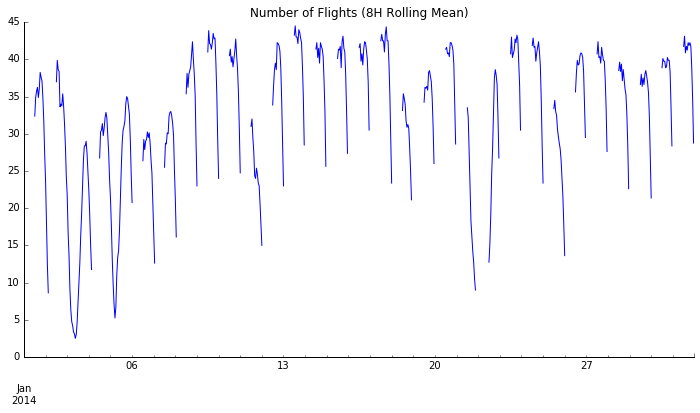

In [6]:
(flights['dep']
    .value_counts()
    .resample('H')
    .sum()
    .rolling(8).mean()
    .plot(figsize=(12, 6),
          title="Number of Flights (8H Rolling Mean)"))
sns.despine()

We can plot the count of flights per carrier:

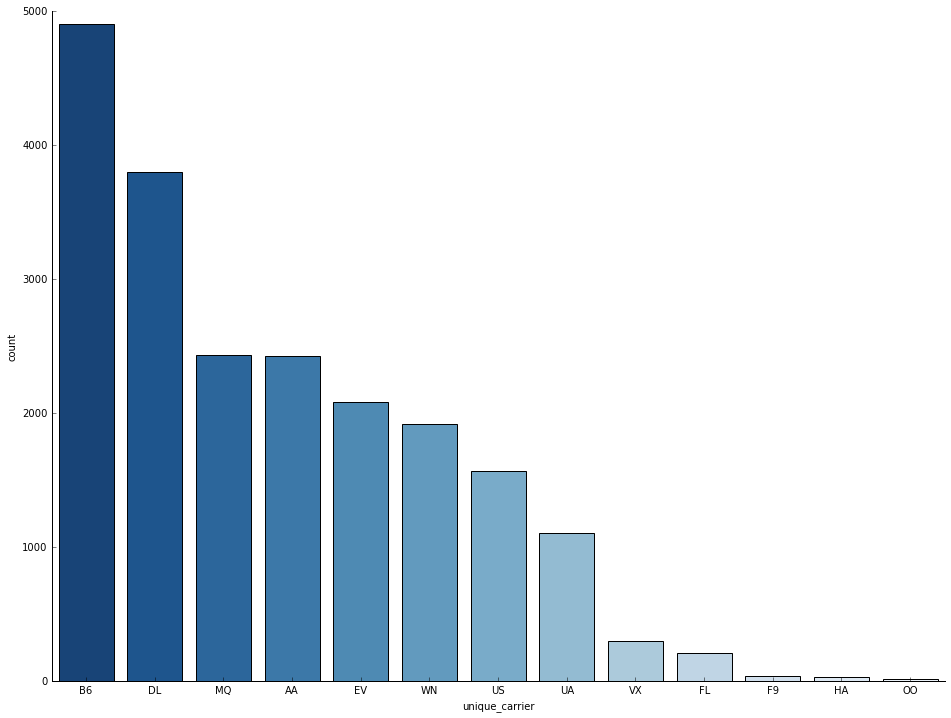

In [10]:
sns.countplot(
    flights['unique_carrier'],
    order=flights['unique_carrier'].value_counts().index,
    palette='Blues_r'
)
sns.despine()

And the joint distribution of departure and arrival delays:

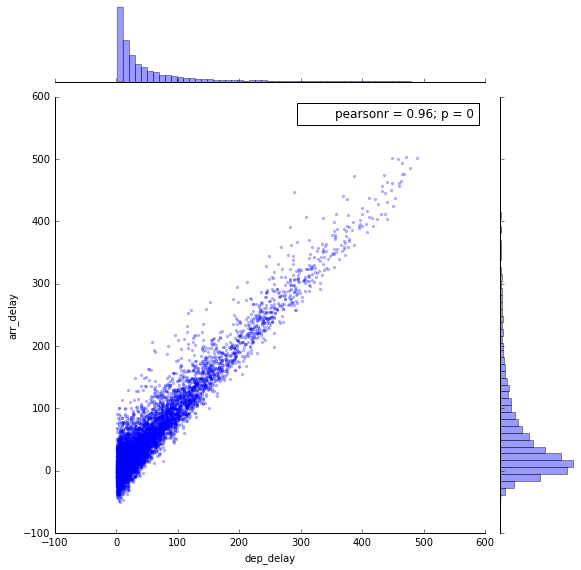

In [11]:
sns.jointplot('dep_delay', 'arr_delay',
              flights.loc[(flights['dep_delay'] > 1) &
                          (flights['dep_delay'] < 500)],
              alpha=.25, marker='.', size=8);

We'll explore some of those methods and visualization techniques later.
For now we'll turn to the more fundamental operation of indexing.

By indexing, we mean selecting subsets of your data.
It's a good starting point, because it comes up in so many other places;
It's a terrible starting point because it's somewhat complicated, and somewhat boring.

## Goals of Indexing

There are many ways you might want to specify which subset you want to select:

- Like lists, you can index by integer position.
- Like dictionaries, you can index by label.
- Like NumPy arrays, you can index by boolean masks.
- You can index with a scalar, `slice`, or array
- Any of these should work on the index (row labels), or columns of a DataFrame, or both
- And any of these should work on hierarchical indexes.

## The Basic Rules

1. Use `__getitem__` (square brackets) to select columns of a `DataFrame`

    ```python
    >>> df[['a', 'b', 'c']]
    ```

2. Use `.loc` for label-based indexing (rows and columns)

    ```python
    >>> df.loc[row_labels, column_labels]
    ```

3. Use `.iloc` for position-based indexing (rows and columns)

    ```python
    >>> df.iloc[row_positions, column_positions]
    ```

---

The arguments to `.loc` and `.iloc` are `.loc[row_indexer, column_indexer]`. An indexer can be one of

- A scalar or array (of labels or integer positions)
- A `slice` object (including `:` for everything)
- A boolean mask

The column indexer is optional.
We'll walk through all the combinations below.

Let's get a DataFrame with a labeled index by selecting the
first flight for each carrier. We'll talk about `groupby` later.

In [30]:
flights.columns

Index([u'fl_date', u'unique_carrier', u'airline_id', u'tail_num', u'fl_num',
       u'origin', u'dest', u'dep_time', u'dep_delay', u'arr_time',
       u'arr_delay', u'cancelled', u'arr', u'dep'],
      dtype='object')

In [31]:
flights.iloc[:,5:9].columns

Index([u'origin', u'dest', u'dep_time', u'dep_delay'], dtype='object')

In [38]:
flights.groupby(['origin', 'dest']).size()

origin  dest
ALB     ATL      87
        BWI     123
        CLE      26
        CLT      63
        EWR      47
               ... 
SYR     JFK      93
        LGA      47
        MCO      37
        MSP       1
        ORD     183
Length: 187, dtype: int64

In [46]:
flights.groupby(['origin', 'dest']).dep_time.mean().sort_values()

origin  dest
BUF     IAD      556.00
JFK     SAT      621.00
ALB     LAS      675.75
SWF     MCO      694.07
BUF     RSW      703.48
                 ...   
JFK     ABQ    2,025.21
        DEN    2,077.00
LGA     OMA    2,090.78
        BGR    2,108.90
        DSM    2,120.00
Name: dep_time, Length: 187, dtype: float64

In [45]:
t.sort_values()

origin  dest
BUF     IAD      556.00
JFK     SAT      621.00
ALB     LAS      675.75
SWF     MCO      694.07
BUF     RSW      703.48
                 ...   
JFK     ABQ    2,025.21
        DEN    2,077.00
LGA     OMA    2,090.78
        BGR    2,108.90
        DSM    2,120.00
Name: dep_time, Length: 187, dtype: float64

In [32]:
flights.unique_carrier.value_counts()

B6    4902
DL    3803
MQ    2434
AA    2427
EV    2080
      ... 
VX     301
FL     206
F9      33
HA      29
OO      11
Name: unique_carrier, Length: 13, dtype: int64

In [34]:
first = flights.groupby("unique_carrier").size()
first

unique_carrier
AA    2427
B6    4902
DL    3803
EV    2080
F9      33
      ... 
OO      11
UA    1106
US    1568
VX     301
WN    1917
Length: 13, dtype: int64

## 1. Selecting Columns with `__getitem__`

Let's select the two delay columns. Since we're *only* filtering the columns (not rows), we can use dictionary-like `[]` to do the slicing.

In [13]:
first[['dep_delay', 'arr_delay']]

,dep_delay,arr_delay
unique_carrier,,
AA,14.00,13.00
B6,90.00,55.00
DL,10.00,10.00
EV,-5.00,31.00
F9,35.00,47.00
...,...,...
OO,49.00,47.00
UA,0.00,8.00
US,-6.00,-39.00


One potential source of confusion: python uses `[]` for two purposes

1. building a list
2. slicing with `__getitem__`

In [14]:
# 1. build the list cols
cols = ['dep_delay', 'arr_delay']
# 2. slice, with cols as the argument to `__getitem__`
first[cols]

,dep_delay,arr_delay
unique_carrier,,
AA,14.00,13.00
B6,90.00,55.00
DL,10.00,10.00
EV,-5.00,31.00
F9,35.00,47.00
...,...,...
OO,49.00,47.00
UA,0.00,8.00
US,-6.00,-39.00


<div class="alert alert-success" data-title="Select Columns by Name">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise: Select Columns by Name</h1>
</div>
<p>Select the two airport-name columns, `'origin'` and `'dest'`, from `first`</p>

In [14]:
# Your code here...


In [16]:
%load solutions/indexing_00.py

,origin,dest
unique_carrier,,
AA,JFK,LAX
B6,SYR,JFK
DL,LGA,ATL
EV,HPN,ORD
F9,LGA,DEN
...,...,...
OO,SYR,ORD
UA,LGA,ORD
US,JFK,PHX


## Column `.` lookup

As a convenience, pandas attaches the column names to your `DataFrame` when they're valid [python identifiers](https://docs.python.org/3/reference/lexical_analysis.html), and don't override one of the ([many](http://pandas.pydata.org/pandas-docs/stable/api.html#dataframe)) methods on `DataFrame`

In [17]:
# Same as flights['tail_num'].value_counts()
flights.tail_num.value_counts()

N292JB    76
N258JB    69
N306JB    68
N523MQ    59
N324JB    58
          ..
N527AA     1
N1610D     1
N124US     1
N76508     1
N77258     1
Name: tail_num, Length: 2734, dtype: int64

This is nice when working interactively, especially as tab completion works with `flights.tail_num.<TAB>`, but doesn't with `flights['tail_num'].<TAB>`.
Still, since pandas could add methods in the future that clash with your column names, it's recommended to stick with `__getitem__` for production code.
This will always work, even when you shadow a DataFrame method

In [18]:
x = pd.DataFrame({"mean": [1, 2, 3]})
x

,mean
0,1
1,2
2,3


In [19]:
# returns the method, not the column
x.mean

<bound method DataFrame.mean of    mean
0     1
1     2
2     3>

Finally, you can't *assign* with `.`, while you can with `__setitem__` (square brackets on the left-hand side of an `=`):

In [20]:
x.wrong = ['a', 'b', 'c']
x['right'] = ['a', 'b', 'c']
x

,mean,right
0,1,a
1,2,b
2,3,c


In [21]:
x.wrong

['a', 'b', 'c']

`DataFrame`s, like most python objects, allow you to attach arbitrary attributes to any instance.
This means `x.wrong = ...` attaches the thing on the right-hand side to the object on the left.

## Label-Based Indexing with `.loc`

You can slice rows by label (and optionally the columns too) with `.loc`.
Let's select the rows for the carriers 'AA', 'DL', 'US', and 'WN'.

In [47]:
carriers = ['AA', 'DL', 'US', 'WN']
# Select those carriers by label
first.loc[carriers]  # no column indexer

unique_carrier
AA    2427
DL    3803
US    1568
WN    1917
dtype: int64

Indexing both rows and columns:

In [23]:
# select just `carriers` and origin, dest, and dep_delay
first.loc[carriers, ['origin', 'dest', 'dep_delay']]

,origin,dest,dep_delay
unique_carrier,,,
AA,JFK,LAX,14.00
DL,LGA,ATL,10.00
US,JFK,PHX,-6.00
WN,ALB,BWI,17.00


Pandas will *reduce dimensionality* when possible, so slicing with a scalar on either axis will return a `Series`.

In [24]:
# select just tail_num for those `carriers`
first.loc[carriers, 'tail_num']

unique_carrier
AA    N338AA
DL    N930DL
US    N546UW
WN    N625SW
Name: tail_num, dtype: object

And scalars on both axes will return a scalar.

In [25]:
first.loc['AA', 'tail_num']

'N338AA'

## `slice` objects

You can pass a `slice` object (made with a `:`). They make sense when your index is sorted, which ours is.

In [26]:
# slice from AA to DL
first.loc['AA':'DL']

,fl_date,airline_id,tail_num,fl_num,origin,dest,dep_time,dep_delay,arr_time,arr_delay,cancelled,arr,dep
unique_carrier,,,,,,,,,,,,,
AA,2014-01-01,19805,N338AA,1,JFK,LAX,914.00,14.00,"1,238.00",13.00,0.00,2014-01-01 12:38:00,2014-01-01 09:14:00
B6,2014-01-01,20409,N318JB,115,SYR,JFK,720.00,90.00,808.00,55.00,0.00,2014-01-01 08:08:00,2014-01-01 07:20:00
DL,2014-01-01,19790,N930DL,61,LGA,ATL,"1,810.00",10.00,"2,054.00",10.00,0.00,2014-01-01 20:54:00,2014-01-01 18:10:00


Notice that the slice is inclusive on *both* sides *when using* `.loc` (`.iloc` follows the usual python semantics of closed on the left, open on the right).

<div class="alert alert-success" data-title="Index Rows and Columns">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise: Index Rows and Columns</h1>
</div>
<p>
Select the columns `tail_num`, `origin`, and `dest` for the carriers `US`, `VX`, and `WN` from `first`.</p>

In [27]:
# Your code here...


In [29]:
%load solutions/indexing_loc.py

,tail_num,origin,dest
unique_carrier,,,
US,N546UW,JFK,PHX
VX,N361VA,JFK,SFO
WN,N625SW,ALB,BWI


## Boolean Indexing

Filter using a *1-dimensional* boolean array with the same length.

This is esstentially a SQL `WHERE` clause.
You filter the rows according to some condition.
For example, let's select flights that departed from the top-5 most common airports.

In [30]:
# Get the counts for `flights.origin`
origin_counts = flights.origin.value_counts()
origin_counts

LGA    8530
JFK    7878
BUF    1348
ROC     676
HPN     615
       ... 
SYR     554
ISP     398
ELM     105
SWF      62
ART      58
Name: origin, Length: 11, dtype: int64

[`Series.value_counts`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.value_counts.html) will return a Series where the index is the set of unique values, and the values are the number of occurrances of that value.
It's sorted in descending order, so we can get the 5 most common labels with:

In [31]:
# Get a boolean mask for whether `counts` is in the top 5.
top5 = origin_counts.index[:5]
top5

Index(['LGA', 'JFK', 'BUF', 'ROC', 'HPN'], dtype='object')

We'll test whether any given row from `filghts` is in the top 5 using the `.isin` method:

In [32]:
mask = flights.origin.isin(top5)
mask

0        True
1        True
2        True
3        True
4        True
         ... 
20812    True
20813    True
20814    True
20815    True
20816    True
Name: origin, Length: 20817, dtype: bool

This is a *boolean mask*, which can be passed into `.loc`.

In [33]:
flights.loc[mask, ['origin', 'dest']]

,origin,dest
0,JFK,LAX
1,JFK,LAX
2,JFK,LAX
3,LGA,PBI
4,JFK,LAX
...,...,...
20812,ROC,ORD
20813,LGA,CLE
20814,LGA,IAH
20815,LGA,IAH


You can pass boolean masks to regular `[]`, `.loc`, or `.iloc`.

Boolean indexers are useful because so many operations can produce an array of booleans.

- null checks (`.isnull`, `.notnull`)
- container checks (`.isin`)
- boolean aggregations (`.any`, `.all`)
- comparisions (`.gt`, `.lt`, etc.)

In [34]:
# Select rows where `dep` is null

flights.loc[flights.dep.isnull()]

,fl_date,unique_carrier,airline_id,tail_num,fl_num,origin,dest,dep_time,dep_delay,arr_time,arr_delay,cancelled,arr,dep
29,2014-01-01,AA,19805,N3EAAA,359,LGA,ORD,nan,nan,nan,nan,1.00,NaT,NaT
31,2014-01-01,AA,19805,N542AA,371,LGA,ORD,nan,nan,nan,nan,1.00,NaT,NaT
195,2014-01-01,B6,20409,N913JB,1103,JFK,SJU,nan,nan,nan,nan,1.00,NaT,NaT
209,2014-01-01,B6,20409,N193JB,518,JFK,BOS,nan,nan,nan,nan,1.00,NaT,NaT
359,2014-01-01,EV,20366,N17159,4130,SYR,CLE,nan,nan,nan,nan,1.00,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20645,2014-01-31,DL,19790,N908DA,2129,ROC,ATL,nan,nan,nan,nan,1.00,NaT,NaT
20653,2014-01-31,DL,19790,N965DL,2165,JFK,TPA,nan,nan,nan,nan,1.00,NaT,NaT
20702,2014-01-31,MQ,20398,N672MQ,3075,SYR,ORD,nan,nan,nan,nan,1.00,NaT,NaT
20716,2014-01-31,MQ,20398,N507MQ,3281,LGA,CMH,nan,nan,nan,nan,1.00,NaT,NaT


<div class="alert alert-success" data-title="Boolean Indexing">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise: Boolean Indexing</h1>
</div>

<p>Select the rows of `flights` where the flight was cancelled (`cancelled == 1`)</p>

In [35]:
# Your code here

In [37]:
%load solutions/indexing_cancelled.py

,fl_date,unique_carrier,airline_id,tail_num,fl_num,origin,dest,dep_time,dep_delay,arr_time,arr_delay,cancelled,arr,dep
29,2014-01-01,AA,19805,N3EAAA,359,LGA,ORD,nan,nan,nan,nan,1.00,NaT,NaT
31,2014-01-01,AA,19805,N542AA,371,LGA,ORD,nan,nan,nan,nan,1.00,NaT,NaT
195,2014-01-01,B6,20409,N913JB,1103,JFK,SJU,nan,nan,nan,nan,1.00,NaT,NaT
209,2014-01-01,B6,20409,N193JB,518,JFK,BOS,nan,nan,nan,nan,1.00,NaT,NaT
359,2014-01-01,EV,20366,N17159,4130,SYR,CLE,nan,nan,nan,nan,1.00,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20645,2014-01-31,DL,19790,N908DA,2129,ROC,ATL,nan,nan,nan,nan,1.00,NaT,NaT
20653,2014-01-31,DL,19790,N965DL,2165,JFK,TPA,nan,nan,nan,nan,1.00,NaT,NaT
20702,2014-01-31,MQ,20398,N672MQ,3075,SYR,ORD,nan,nan,nan,nan,1.00,NaT,NaT
20716,2014-01-31,MQ,20398,N507MQ,3281,LGA,CMH,nan,nan,nan,nan,1.00,NaT,NaT


<div class="alert alert-success" data-title="Boolean Indexing (2)">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise: Boolean Indexing (2)</h1>
</div>

<p>Filter down to rows where the departure **`hour`** is before 6:00 or after 18:00.</p>

- Hint: Use the `flights.dep.dt` namespace. See the attributes [here](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DatetimeIndex.html) or use tab-completion on `flights.dep.dt.<tab>` to find an attribute giving the hour component
- Hint: NumPy and pandas use `|` for elementwise `or`, and `&` for elementwise `and` between two boolean arrays
- Hint: Be careful with [Python's order of operations](https://docs.python.org/3/reference/expressions.html#operator-precedence) between comparison operators (`<`, `>`) and NumPy's logical operators `|` and `&`. If your first attempt raises a `TypeError`, try including some parenthesis.

In [38]:
# Your code here...


In [40]:
%load solutions/indexing_01.py

,fl_date,unique_carrier,airline_id,tail_num,fl_num,origin,dest,dep_time,dep_delay,arr_time,arr_delay,cancelled,arr,dep
2,2014-01-01,AA,19805,N327AA,21,JFK,LAX,"1,902.00",2.00,"2,224.00",9.00,0.00,2014-01-01 22:24:00,2014-01-01 19:02:00
5,2014-01-01,AA,19805,N323AA,185,JFK,LAX,"2,133.00",-2.00,37.00,-18.00,0.00,2014-01-01 00:37:00,2014-01-01 21:33:00
8,2014-01-01,AA,19805,N3HYAA,235,JFK,SEA,"1,848.00",-2.00,"2,206.00",-14.00,0.00,2014-01-01 22:06:00,2014-01-01 18:48:00
11,2014-01-01,AA,19805,N336AA,181,JFK,LAX,"1,907.00",142.00,"2,223.00",133.00,0.00,2014-01-01 22:23:00,2014-01-01 19:07:00
16,2014-01-01,AA,19805,N3KHAA,301,LGA,ORD,553.00,-7.00,739.00,-6.00,0.00,2014-01-01 07:39:00,2014-01-01 05:53:00


## Position-Based Indexing with `.iloc`

This takes the same basic forms as `.loc`, except you use integers to designate *positions* instead of labels.

In [41]:
first.iloc[[0, 1, 2], [1, 2]]

,airline_id,tail_num
unique_carrier,,
AA,19805,N338AA
B6,20409,N318JB
DL,19790,N930DL


You can use scalars, arrays, boolean masks, or slices.
You can also use negative indicies to slice from the end like regular python lists or numpy arrays.

The one notable difference compared to label-based indexing is with `slice` objects.
Recall that `.loc` included both ends of the slice.
`.iloc` uses the usual python behavior of slicing up to, but not including, the end point:

In [42]:
# select the first two rows, and the 3rd, 4th, and 5th columns
first.iloc[:2, 3:6]

,fl_num,origin,dest
unique_carrier,,,
AA,1,JFK,LAX
B6,115,SYR,JFK


## Dropping rows or columns

What if you want all items *except* for some?

```
DataFrame.drop(labels, axis=0, ...)

Parameters
----------
labels : single label or list-like
axis : int or axis name
    - 0 / 'index', look in the index.
    - 1 / 'columns', look in the columns
```

<div class="alert alert-success" data-title="Dropping Row Labels">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise: Dropping Row Labels</h1>
</div>
<p>Use `first.drop` to select all the rows *except* `EV` and `F9`.</p>

In [43]:
# Your code here

In [46]:
%load solutions/indexing_drop_index.py

,fl_date,airline_id,tail_num,fl_num,origin,dest,dep_time,dep_delay,arr_time,arr_delay,cancelled,arr,dep
unique_carrier,,,,,,,,,,,,,
AA,2014-01-01,19805,N338AA,1,JFK,LAX,914.00,14.00,"1,238.00",13.00,0.00,2014-01-01 12:38:00,2014-01-01 09:14:00
B6,2014-01-01,20409,N318JB,115,SYR,JFK,720.00,90.00,808.00,55.00,0.00,2014-01-01 08:08:00,2014-01-01 07:20:00
DL,2014-01-01,19790,N930DL,61,LGA,ATL,"1,810.00",10.00,"2,054.00",10.00,0.00,2014-01-01 20:54:00,2014-01-01 18:10:00
FL,2014-01-01,20437,N952AT,63,LGA,ATL,"1,146.00",-5.00,"1,409.00",-10.00,0.00,2014-01-01 14:09:00,2014-01-01 11:46:00
HA,2014-01-01,19690,N382HA,51,JFK,HNL,906.00,6.00,"1,503.00",-7.00,0.00,2014-01-01 15:03:00,2014-01-01 09:06:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
OO,2014-01-07,20304,N732SK,6258,SYR,ORD,"1,721.00",49.00,"1,834.00",47.00,1.00,2014-01-08 18:34:00,2014-01-08 17:21:00
UA,2014-01-01,19977,N413UA,255,LGA,ORD,824.00,0.00,"1,006.00",8.00,0.00,2014-01-01 10:06:00,2014-01-01 08:24:00
US,2014-01-01,20355,N546UW,629,JFK,PHX,"1,624.00",-6.00,"1,932.00",-39.00,0.00,2014-01-01 19:32:00,2014-01-01 16:24:00


<div class="alert alert-success" data-title="Drop a column">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise: Drop a column</h1>
</div>
<p>`flights.airline_id` is redundent with `unique_carrier`. Drop `airline_id`.</p>

In [ ]:
# your code here


In [48]:
%load solutions/indexing_drop_columns.py

,fl_date,unique_carrier,tail_num,fl_num,origin,dest,dep_time,dep_delay,arr_time,arr_delay,cancelled,arr,dep
0,2014-01-01,AA,N338AA,1,JFK,LAX,914.00,14.00,"1,238.00",13.00,0.00,2014-01-01 12:38:00,2014-01-01 09:14:00
1,2014-01-01,AA,N335AA,3,JFK,LAX,"1,157.00",-3.00,"1,523.00",13.00,0.00,2014-01-01 15:23:00,2014-01-01 11:57:00
2,2014-01-01,AA,N327AA,21,JFK,LAX,"1,902.00",2.00,"2,224.00",9.00,0.00,2014-01-01 22:24:00,2014-01-01 19:02:00
3,2014-01-01,AA,N3EHAA,29,LGA,PBI,722.00,-8.00,"1,014.00",-26.00,0.00,2014-01-01 10:14:00,2014-01-01 07:22:00
4,2014-01-01,AA,N319AA,117,JFK,LAX,"1,347.00",2.00,"1,706.00",1.00,0.00,2014-01-01 17:06:00,2014-01-01 13:47:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20812,2014-01-31,UA,N54711,1253,ROC,ORD,801.00,-4.00,908.00,4.00,0.00,2014-01-31 09:08:00,2014-01-31 08:01:00
20813,2014-01-31,UA,N77525,1429,LGA,CLE,"1,522.00",-10.00,"1,649.00",-31.00,0.00,2014-01-31 16:49:00,2014-01-31 15:22:00
20814,2014-01-31,UA,N37293,1456,LGA,IAH,719.00,-6.00,"1,006.00",-20.00,0.00,2014-01-31 10:06:00,2014-01-31 07:19:00
20815,2014-01-31,UA,N24729,1457,LGA,IAH,852.00,7.00,"1,156.00",-6.00,0.00,2014-01-31 11:56:00,2014-01-31 08:52:00


This is our first time seeing the `axis` keyword argument.
It comes up a lot in pandas and NumPy. `axis='index'` (or 0) means
operate on the index (e.g. drop labels from the index).
`axis='columns'` (or 1) means operate on the columns.

## Special Case: `DateTimeIndex`

> Easier slicing with strings

Pandas has really good support for time series data, including a few conveniences to make indexing easier.
First let's get a DataFrame with a `DatetimeIndex`, another specialied index type like we saw with `RangeIndex`.

In [49]:
# We'll talk about resample later
# This gets the average delays per hour
delays = flights.resample("H", on="arr")[['dep_delay', 'arr_delay']].mean()
delays.head()

,dep_delay,arr_delay
arr,,
2014-01-01 00:00:00,32.69,41.56
2014-01-01 01:00:00,96.75,99.00
2014-01-01 02:00:00,103.75,112.75
2014-01-01 03:00:00,110.00,116.00
2014-01-01 04:00:00,13.50,10.25


`delays` has a `DatetimeIndex`:

In [50]:
delays.index

DatetimeIndex(['2014-01-01 00:00:00', '2014-01-01 01:00:00',
               '2014-01-01 02:00:00', '2014-01-01 03:00:00',
               '2014-01-01 04:00:00', '2014-01-01 05:00:00',
               '2014-01-01 06:00:00', '2014-01-01 07:00:00',
               '2014-01-01 08:00:00', '2014-01-01 09:00:00',
               ...
               '2014-01-31 15:00:00', '2014-01-31 16:00:00',
               '2014-01-31 17:00:00', '2014-01-31 18:00:00',
               '2014-01-31 19:00:00', '2014-01-31 20:00:00',
               '2014-01-31 21:00:00', '2014-01-31 22:00:00',
               '2014-01-31 23:00:00', '2014-02-01 00:00:00'],
              dtype='datetime64[ns]', name='arr', length=745, freq=None)

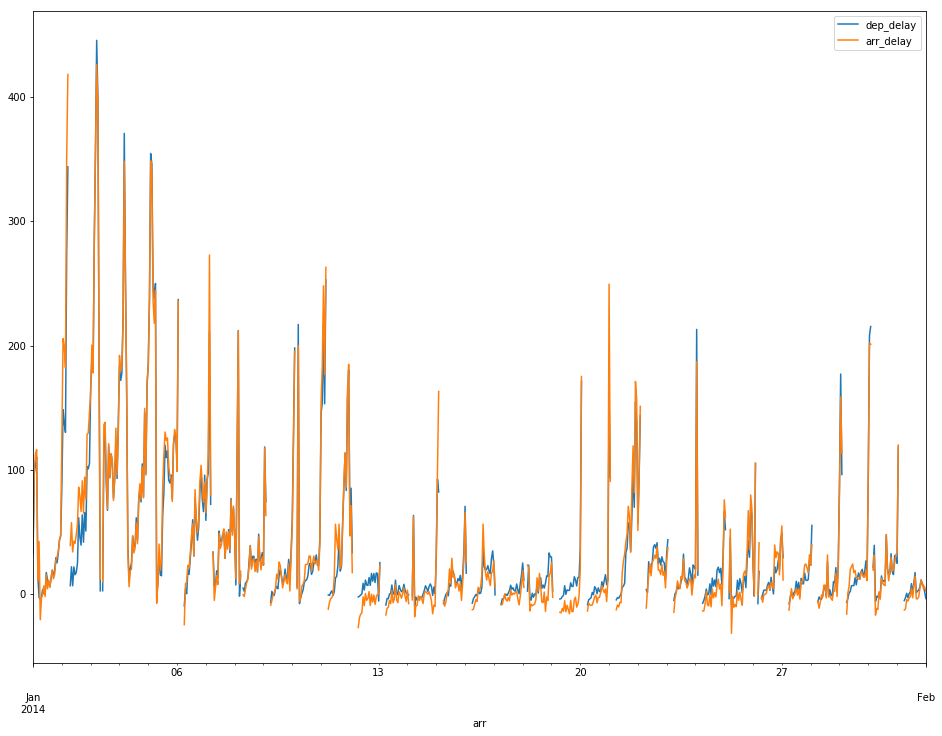

In [51]:
delays.plot();

Since `delays.index` is a `DatetimeIndex`, we can use [partial string indexing](http://pandas.pydata.org/pandas-docs/stable/timeseries.html#datetimeindex-partial-string-indexing) to easily select subsets of the data.
The basic idea is to specify the datetime up to whatever resolution you care about.
For example, to select all the flights on the 12th (a daily resolution):

In [52]:
delays.loc['2014-01-12']

,dep_delay,arr_delay
arr,,
2014-01-12 00:00:00,58.75,46.58
2014-01-12 01:00:00,85.00,71.00
2014-01-12 02:00:00,33.00,17.00
2014-01-12 03:00:00,nan,nan
2014-01-12 04:00:00,6.50,-1.00
...,...,...
2014-01-12 19:00:00,10.06,-6.85
2014-01-12 20:00:00,16.23,-1.09
2014-01-12 21:00:00,8.95,-8.65


Without parital string indexing, you'd need to do something like

In [53]:
delays[(delays.index.year == 2014) & (delays.index.month == 1) & (delays.index.day == 12)]

,dep_delay,arr_delay
arr,,
2014-01-12 00:00:00,58.75,46.58
2014-01-12 01:00:00,85.00,71.00
2014-01-12 02:00:00,33.00,17.00
2014-01-12 03:00:00,nan,nan
2014-01-12 04:00:00,6.50,-1.00
...,...,...
2014-01-12 19:00:00,10.06,-6.85
2014-01-12 20:00:00,16.23,-1.09
2014-01-12 21:00:00,8.95,-8.65


Which isn't very fun.

<div class="alert alert-success" data-title="Datetime Indexing">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise: Datetime Indexing</h1>
</div>
<p>
Slice `delays` to select all rows from 12:00 on January 3rd, to 12:00 on the 10th.</p>

In [54]:
# Your code

In [56]:
%load solutions/indexing_datetime.py

,dep_delay,arr_delay
arr,,
2014-01-03 12:00:00,131.00,138.17
2014-01-03 13:00:00,87.77,96.15
2014-01-03 14:00:00,67.12,68.19
2014-01-03 15:00:00,119.12,120.92
2014-01-03 16:00:00,93.74,93.11
...,...,...
2014-01-10 08:00:00,0.07,6.22
2014-01-10 09:00:00,3.00,7.74
2014-01-10 10:00:00,8.87,10.53


<div class="alert alert-success" data-title="Thought Exercise">
  <h1><i class="fa fa-lightbulb-o" aria-hidden="true"></i> Thought Exercise</h1>
</div>
<p>
Why does pandas use a property like `.loc[..., ...]`, rather than a method like `.loc(..., ...)`?</p>

- Hint: Where in the language can you use `foo.loc[...]`, but not `foo.loc(...)`?

In [71]:
%load solutions/indexing_thoughts.py

,fl_date,airline_id,tail_num,fl_num,origin,dest,dep_time,dep_delay,arr_time,arr_delay,cancelled,arr,dep
unique_carrier,,,,,,,,,,,,,
AA,2014-01-01,19805,N338AA,-1,JFK,LAX,914.00,14.00,"1,238.00",13.00,0.00,2014-01-01 12:38:00,2014-01-01 09:14:00
B6,2014-01-01,20409,N318JB,115,SYR,JFK,720.00,90.00,808.00,55.00,0.00,2014-01-01 08:08:00,2014-01-01 07:20:00
DL,2014-01-01,19790,N930DL,61,LGA,ATL,"1,810.00",10.00,"2,054.00",10.00,0.00,2014-01-01 20:54:00,2014-01-01 18:10:00
EV,2014-01-01,20366,N14977,3259,HPN,ORD,731.00,-5.00,940.00,31.00,0.00,2014-01-01 09:40:00,2014-01-01 07:31:00
F9,2014-01-01,20436,N209FR,507,LGA,DEN,"1,804.00",35.00,"2,047.00",47.00,0.00,2014-01-01 20:47:00,2014-01-01 18:04:00


## Summary

- Introducted to `DataFrame` (2-D tabel) and `Series` (1-D array)
- Both have *row labels*, `DataFrame` also has `column labels`
- Saw `.loc` for labeled indexing and `.iloc` for positional indexing
- `.loc`, `.iloc`, and `__getitem__` all accept boolean masks too

## Additional Exercises

Some additional exercises focused on indexing:

In [51]:
from IPython.display import IFrame

IFrame("http://vincentarelbundock.github.io/Rdatasets/doc/ISLR/Auto.html", 750, 900)

In [59]:
url = "http://vincentarelbundock.github.io/Rdatasets/csv/ISLR/Auto.csv"
cars = pd.read_csv(url, index_col=0)

In [60]:
cars.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
1,18.00,8,307.00,130,3504,12.00,70,1,chevrolet chevelle malibu
2,15.00,8,350.00,165,3693,11.50,70,1,buick skylark 320
3,18.00,8,318.00,150,3436,11.00,70,1,plymouth satellite
4,16.00,8,304.00,150,3433,12.00,70,1,amc rebel sst
5,17.00,8,302.00,140,3449,10.50,70,1,ford torino


In [61]:
yearly = cars.groupby("year").mean()
yearly.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,origin
year,,,,,,,
70,17.69,6.76,281.41,147.83,"3,372.79",12.95,1.31
71,21.11,5.63,213.89,107.04,"3,030.59",15.00,1.44
72,18.71,5.82,218.38,120.18,"3,237.71",15.12,1.54
73,17.10,6.38,256.88,130.47,"3,419.03",14.31,1.38
74,22.77,5.23,170.65,94.23,"2,878.04",16.17,1.69


 <div class="alert alert-success" data-title="">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise</h1>
</div>
<p>
Select the engine-related columns (cylinders, displacement, horsepower) from `cars`.
</p>

In [63]:
%load solutions/indexing_ex1_engine_columns.py

,cylinders,displacement,horsepower
1,8,307.00,130
2,8,350.00,165
3,8,318.00,150
4,8,304.00,150
5,8,302.00,140
...,...,...,...
393,4,140.00,86
394,4,97.00,52
395,4,135.00,84
396,4,120.00,79


 <div class="alert alert-success" data-title="">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise</h1>
</div>
<p>
Select every 5th row of `cars`.
</p>

Hint: See [here](http://stackoverflow.com/a/509295) for all the options on slicing.

In [65]:
%load solutions/indexing_ex2_5th.py

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
1,18.00,8,307.00,130,3504,12.00,70,1,chevrolet chevelle malibu
6,15.00,8,429.00,198,4341,10.00,70,1,ford galaxie 500
11,15.00,8,383.00,170,3563,10.00,70,1,dodge challenger se
16,22.00,6,198.00,95,2833,15.50,70,1,plymouth duster
21,25.00,4,110.00,87,2672,17.50,70,2,peugeot 504
...,...,...,...,...,...,...,...,...,...
376,37.00,4,91.00,68,2025,18.20,82,3,mazda glc custom l
381,36.00,4,107.00,75,2205,14.50,82,3,honda accord
386,25.00,6,181.00,110,2945,16.40,82,1,buick century limited
391,36.00,4,135.00,84,2370,13.00,82,1,dodge charger 2.2


 <div class="alert alert-success" data-title="">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise</h1>
</div>

<p>Select years `70`, `75`, `80`, and `82` and columns `horsepower` and `weight` from `yearly`.</p>

In [67]:
%load solutions/indexing_ex3_years.py

,horsepower,weight
year,,
70,147.83,"3,372.79"
75,101.07,"3,176.80"
80,77.48,"2,441.59"
82,81.47,"2,434.17"


 <div class="alert alert-success" data-title="">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise</h1>
</div>

<p>Select rows in `cars` with at least 30 MPG.</p>

In [69]:
%load solutions/indexing_ex4_mpg.py

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
54,31.00,4,71.00,65,1773,19.00,71,3,toyota corolla 1200
55,35.00,4,72.00,69,1613,18.00,71,3,datsun 1200
130,31.00,4,79.00,67,1950,19.00,74,3,datsun b210
132,32.00,4,71.00,65,1836,21.00,74,3,toyota corolla 1200
145,31.00,4,76.00,52,1649,16.50,74,3,toyota corona
...,...,...,...,...,...,...,...,...,...
390,32.00,4,144.00,96,2665,13.90,82,3,toyota celica gt
391,36.00,4,135.00,84,2370,13.00,82,1,dodge charger 2.2
394,44.00,4,97.00,52,2130,24.60,82,2,vw pickup
395,32.00,4,135.00,84,2295,11.60,82,1,dodge rampage


 <div class="alert alert-success" data-title="">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise</h1>
</div>

<p>How many cars have at least 30 MPG and at least 5 cylinders?</p>

In [70]:
# %load solutions/indexing_ex5_mpg_and_cylinders.py
len(cars[(cars.mpg >= 30) & (cars.cylinders >= 5)])

4